In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, BatchNormalization, ReLU, Concatenate
from tensorflow.keras.utils import plot_model

### Remind
因為這台主機是我們在中央的主機，他有好的GPU可以加速訓練，但是他的CPU比較慢，跑迴圈會比較慢，所以我直接把整理過後的DataFrame存下來，直接讀來用就可以了，如果你要修改前面Data的部分，麻煩先用自己電腦跑完，存成json檔，再替換上來。
### Result
以下是我跑的結果，https://www.notion.so/analysis-a68c61cf05f8483db07241aa25841a94
### Problem
1. 我發現原本實作網路架構和原本paper有出入，原本paper有測試幾種網路層數和神經元數量，而這篇實作是採用(256,256,256)，這種架構我沒在paper上看到類似的，因此我有將網路改成(1024,512,256)去還原paper上Depth 3的網路架構，雖然validation結果沒有變好，但train的結果合理的顯著上升，因此麻煩實作上多確認是否與paper有出入。
2. 訓練結果看起來很差似乎是正常，可參考paper上Figure 6。

# 新年快樂!!!
感謝(ಥ_ʖಥ)
### Problem
1. 以下為照著paper架構寫出來的，第二部分(ranking)的label是以recall出來的前十部電影的rating來做，我用paper上的sparse_categorical_crossentropy會有shape的問題，上網查說10筆rating這種類別型結果要用categorical_crossentropy當作loss function，結果如下。loss大概在前五個epoch有下降，之後就一路上升。
2. ml-latest-small有10萬筆rating，但整理過後實際只有610個user，validation acc一直上不去的原因似乎在於用610筆資料估5萬部電影的選擇太困難。我試著使用ml-latest有270萬筆rating，整理過後有283225個user，但整理完的資料似乎太大要load也很慢，資料處理我可能沒經驗不知道有沒有什麼技巧，想與你討論看看~
3. running?

### Future work
1. 實驗模型不同深度與units數量
2. 比較label取watch_hist最後一個與random的差異
3. labels? 目前資料似乎只有rating可以用
4. features?



### Data Loading

In [2]:
data = pd.read_json("./ml-latest-small/final_data_update.json")
data.head()

,userId,movieId,rating,timestamp,index,title,genres,year,example_age,(no genres listed),...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,all_genres
0,1,1,4.0,0.192846,0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,0.159722,0,...,0,0,0,0,0,0,0,0,0,"2,3,4,5,9"
1,1,2387,5.0,0.192847,2303,Very Bad Things,Comedy|Crime,1998,0.138889,0,...,0,0,0,0,0,0,0,0,0,"5,6"
2,1,2389,2.0,0.192847,2305,Psycho,Crime|Horror|Thriller,1998,0.138889,0,...,1,0,0,0,0,0,1,0,0,"6,11,17"
3,1,2395,5.0,0.192844,2311,Rushmore,Comedy|Drama,1998,0.138889,0,...,0,0,0,0,0,0,0,0,0,"5,8"
4,1,2406,4.0,0.192846,2322,Romancing the Stone,Action|Adventure|Comedy|Romance,1984,0.236111,0,...,0,0,0,0,1,0,0,0,0,"1,2,5,15"


Training dataset

In [3]:
sample_data=data[['userId']]
sample_data = sample_data.drop_duplicates()
sample_data.shape

(610, 1)

In [4]:
watch_hist = data.groupby(['userId'])['movieId'].apply(list).reset_index()
watch_hist["watch_hist"]=watch_hist["movieId"]
watch_hist["labels"]=watch_hist["movieId"]
for i in range(610):
    watch_hist["watch_hist"][i]=(watch_hist["watch_hist"][i])[:-1]
    watch_hist["labels"][i]=(watch_hist["labels"][i])[-1:]
clear_output()
watch_hist.head(3)

,userId,movieId,watch_hist,labels
0,1,"[1, 2387, 2389, 2395, 2406, 2414, 2427, 2450, ...","[1, 2387, 2389, 2395, 2406, 2414, 2427, 2450, ...",[3]
1,2,"[8798, 122882, 115713, 114060, 112552, 109487,...","[8798, 122882, 115713, 114060, 112552, 109487,...",[333]
2,3,"[849, 72378, 70946, 26409, 7991, 7899, 6835, 6...","[849, 72378, 70946, 26409, 7991, 7899, 6835, 6...",[2105]


In [5]:
example_age = data.groupby(['userId'])['example_age'].apply(list).reset_index()
for i in range(610):
    example_age["example_age"][i]=(example_age["example_age"][i])[:-1]
clear_output()
example_age.head(3)

,userId,example_age
0,1,"[0.1597222222, 0.1388888889, 0.1388888889, 0.1..."
1,2,"[0.0972222222, 0.0208333333, 0.0208333333, 0.0..."
2,3,"[0.15277777780000001, 0.0625, 0.1944444444, 0...."


In [6]:
rating = data.groupby(['userId'])['rating'].apply(list).reset_index()
for i in range(610):
    rating["rating"][i]=(rating["rating"][i])[:-1]
clear_output()
rating.head(3)

,userId,rating
0,1,"[4.0, 5.0, 2.0, 5.0, 4.0, 3.0, 5.0, 4.0, 5.0, ..."
1,2,"[3.5, 5.0, 3.5, 2.0, 4.0, 3.0, 5.0, 3.5, 2.5, ..."
2,3,"[5.0, 0.5, 5.0, 4.5, 5.0, 4.5, 5.0, 0.5, 5.0, ..."


In [7]:
rating_time = data.groupby(['userId'])['timestamp'].apply(list).reset_index()
for i in range(610):
    rating_time["timestamp"][i]=(rating_time["timestamp"][i])[:-1]
clear_output()
rating_time.head(3)

,userId,timestamp
0,1,"[0.1928462443, 0.1928468361, 0.1928467952, 0.1..."
1,2,"[0.8702443550000001, 0.8702447946, 0.870244205..."
2,3,"[0.6740257752000001, 0.6740265544, 0.674026062..."


In [8]:
genre_list = data.groupby(['userId'])["all_genres"].unique().apply(list).reset_index()
genre_list['all_genres']=genre_list['all_genres'].apply(lambda x: list(set(','.join(x))) ) 
genre_list['all_genres']=genre_list['all_genres'].apply(lambda x:[ x for x in x if x.isdigit() ])
clear_output()
genre_list.head(3)

,userId,all_genres
0,1,"[8, 3, 4, 2, 6, 9, 7, 0, 5, 1]"
1,2,"[8, 4, 2, 6, 9, 7, 5, 1]"
2,3,"[8, 3, 4, 2, 6, 9, 7, 5, 1]"


In [9]:
user_movie_list = pd.merge(sample_data,watch_hist, how= 'left')
user_movie_list = pd.merge(user_movie_list,rating, how= 'left')
user_movie_list = pd.merge(user_movie_list,rating_time, how= 'left')
user_movie_list = pd.merge(user_movie_list,genre_list, how='left')
user_movie_list = pd.merge(user_movie_list,example_age, how='left')
user_movie_list

,userId,movieId,watch_hist,labels,rating,timestamp,all_genres,example_age
0,1,"[1, 2387, 2389, 2395, 2406, 2414, 2427, 2450, ...","[1, 2387, 2389, 2395, 2406, 2414, 2427, 2450, ...",[3],"[4.0, 5.0, 2.0, 5.0, 4.0, 3.0, 5.0, 4.0, 5.0, ...","[0.1928462443, 0.1928468361, 0.1928467952, 0.1...","[8, 3, 4, 2, 6, 9, 7, 0, 5, 1]","[0.1597222222, 0.1388888889, 0.1388888889, 0.1..."
1,2,"[8798, 122882, 115713, 114060, 112552, 109487,...","[8798, 122882, 115713, 114060, 112552, 109487,...",[333],"[3.5, 5.0, 3.5, 2.0, 4.0, 3.0, 5.0, 3.5, 2.5, ...","[0.8702443550000001, 0.8702447946, 0.870244205...","[8, 4, 2, 6, 9, 7, 5, 1]","[0.0972222222, 0.0208333333, 0.0208333333, 0.0..."
2,3,"[849, 72378, 70946, 26409, 7991, 7899, 6835, 6...","[849, 72378, 70946, 26409, 7991, 7899, 6835, 6...",[2105],"[5.0, 0.5, 5.0, 4.5, 5.0, 4.5, 5.0, 0.5, 5.0, ...","[0.6740257752000001, 0.6740265544, 0.674026062...","[8, 3, 4, 2, 6, 9, 7, 5, 1]","[0.15277777780000001, 0.0625, 0.1944444444, 0...."
3,4,"[595, 599, 708, 759, 800, 892, 898, 899, 126, ...","[595, 599, 708, 759, 800, 892, 898, 899, 126, ...",[1266],"[3.0, 2.0, 4.0, 3.0, 4.0, 4.0, 5.0, 4.0, 1.0, ...","[0.2236574145, 0.1647994253, 0.223779471800000...","[8, 3, 4, 2, 6, 9, 7, 0, 5, 1]","[0.1875, 0.3402777778, 0.15277777780000001, 0...."
4,5,"[380, 318, 261, 290, 474, 364, 608, 592, 515, ...","[380, 318, 261, 290, 474, 364, 608, 592, 515, ...",[316],"[2.0, 3.0, 4.0, 5.0, 4.0, 3.0, 3.0, 3.0, 3.0, ...","[0.0272098396, 0.0272100256, 0.0272105301, 0.0...","[8, 3, 4, 2, 6, 9, 7, 5, 1]","[0.1666666667, 0.1666666667, 0.1666666667, 0.1..."
...,...,...,...,...,...,...,...,...
605,606,"[4351, 5992, 1204, 1569, 27744, 4690, 4572, 22...","[4351, 5992, 1204, 1569, 27744, 4690, 4572, 22...",[111],"[4.0, 4.0, 4.0, 4.0, 4.5, 3.5, 2.0, 4.0, 0.5, ...","[0.4837168021, 0.48658669050000003, 0.48367555...","[8, 3, 4, 2, 6, 9, 7, 0, 5, 1]","[0.1875, 0.1111111111, 0.3888888889, 0.1458333..."
606,607,"[1270, 2889, 434, 1975, 2194, 2529, 377, 695, ...","[1270, 2889, 434, 1975, 2194, 2529, 377, 695, ...",[188],"[3.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 4.0, 3.0, ...","[0.1925104058, 0.1925089066, 0.1901656947, 0.1...","[8, 3, 4, 2, 6, 9, 7, 5, 1]","[0.22916666670000002, 0.1319444444, 0.17361111..."
607,608,"[21, 2616, 588, 185, 4040, 1350, 5219, 51903, ...","[21, 2616, 588, 185, 4040, 1350, 5219, 51903, ...",[587],"[3.5, 3.5, 3.0, 3.0, 1.0, 3.5, 4.5, 2.5, 3.0, ...","[0.44962341650000004, 0.4077649908, 0.40762851...","[8, 3, 4, 2, 6, 9, 7, 0, 5, 1]","[0.1597222222, 0.1944444444, 0.1805555556, 0.1..."
608,609,"[110, 356, 1059, 650, 137, 150, 613, 457, 434,...","[110, 356, 1059, 650, 137, 150, 613, 457, 434,...",[786],"[3.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.0, ...","[0.026908634, 0.0269084635, 0.0269087242, 0.02...","[8, 3, 4, 2, 6, 9, 7, 5, 1]","[0.1597222222, 0.1666666667, 0.152777777800000..."


In [10]:
# USER=239
# train_data = user_movie_list[((user_movie_list.userId >= 1)&(user_movie_list.userId <= USER-1))|((user_movie_list.userId >= USER+1)&(user_movie_list.userId <= 610))]
# test_data = user_movie_list[user_movie_list.userId == USER] # 33794 is Batman Begins

train_data = user_movie_list[(user_movie_list.userId >= 1)&(user_movie_list.userId <= 600)]
test_data = user_movie_list[(user_movie_list.userId >= 601)&(user_movie_list.userId <= 610)]
test_data 

,userId,movieId,watch_hist,labels,rating,timestamp,all_genres,example_age
600,601,"[1197, 47, 1198, 170697, 81834, 79132, 48394, ...","[1197, 47, 1198, 170697, 81834, 79132, 48394, ...",[1203],"[5.0, 4.0, 4.0, 4.0, 4.5, 5.0, 4.0, 5.0, 4.0, ...","[0.9768893487, 0.9769875008000001, 0.976987419...","[8, 3, 4, 2, 6, 9, 7, 0, 5, 1]","[0.21527777780000001, 0.1597222222, 0.25694444..."
601,602,"[364, 194, 551, 527, 172, 410, 125, 553, 110, ...","[364, 194, 551, 527, 172, 410, 125, 553, 110, ...",[586],"[4.0, 2.0, 4.0, 5.0, 3.0, 4.0, 3.0, 2.0, 5.0, ...","[0.017967461900000002, 0.0179687724, 0.0179680...","[8, 3, 4, 2, 6, 9, 7, 0, 5, 1]","[0.1666666667, 0.1597222222, 0.1736111111, 0.1..."
602,603,"[2531, 532, 4786, 923, 1222, 3221, 34, 426, 42...","[2531, 532, 4786, 923, 1222, 3221, 34, 426, 42...",[4529],"[4.0, 2.0, 1.0, 5.0, 3.0, 5.0, 4.0, 4.0, 5.0, ...","[0.19030205860000002, 0.1772658283, 0.24557579...","[8, 3, 4, 2, 6, 9, 7, 0, 5, 1]","[0.3125, 0.1666666667, 0.3125, 0.5347222222, 0..."
603,604,"[32, 300, 315, 327, 317, 62, 316, 272, 19, 60,...","[32, 300, 315, 327, 317, 62, 316, 272, 19, 60,...",[339],"[4.0, 3.0, 4.0, 5.0, 3.0, 4.0, 4.0, 4.0, 1.0, ...","[0.0055734597, 0.0055746448, 0.005573589400000...","[8, 3, 4, 2, 6, 9, 7, 5, 1]","[0.1597222222, 0.1666666667, 0.1666666667, 0.1..."
604,605,"[2759, 2797, 7153, 110, 2145, 2622, 314, 1917,...","[2759, 2797, 7153, 110, 2145, 2622, 314, 1917,...",[34150],"[4.0, 4.5, 5.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, ...","[0.6326425053, 0.6327563898, 0.6327561926, 0.6...","[8, 3, 4, 2, 6, 9, 7, 5, 1]","[0.1319444444, 0.2083333333, 0.104166666700000..."
605,606,"[4351, 5992, 1204, 1569, 27744, 4690, 4572, 22...","[4351, 5992, 1204, 1569, 27744, 4690, 4572, 22...",[111],"[4.0, 4.0, 4.0, 4.0, 4.5, 3.5, 2.0, 4.0, 0.5, ...","[0.4837168021, 0.48658669050000003, 0.48367555...","[8, 3, 4, 2, 6, 9, 7, 0, 5, 1]","[0.1875, 0.1111111111, 0.3888888889, 0.1458333..."
606,607,"[1270, 2889, 434, 1975, 2194, 2529, 377, 695, ...","[1270, 2889, 434, 1975, 2194, 2529, 377, 695, ...",[188],"[3.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 4.0, 3.0, ...","[0.1925104058, 0.1925089066, 0.1901656947, 0.1...","[8, 3, 4, 2, 6, 9, 7, 5, 1]","[0.22916666670000002, 0.1319444444, 0.17361111..."
607,608,"[21, 2616, 588, 185, 4040, 1350, 5219, 51903, ...","[21, 2616, 588, 185, 4040, 1350, 5219, 51903, ...",[587],"[3.5, 3.5, 3.0, 3.0, 1.0, 3.5, 4.5, 2.5, 3.0, ...","[0.44962341650000004, 0.4077649908, 0.40762851...","[8, 3, 4, 2, 6, 9, 7, 0, 5, 1]","[0.1597222222, 0.1944444444, 0.1805555556, 0.1..."
608,609,"[110, 356, 1059, 650, 137, 150, 613, 457, 434,...","[110, 356, 1059, 650, 137, 150, 613, 457, 434,...",[786],"[3.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.0, ...","[0.026908634, 0.0269084635, 0.0269087242, 0.02...","[8, 3, 4, 2, 6, 9, 7, 5, 1]","[0.1597222222, 0.1666666667, 0.152777777800000..."
609,610,"[27604, 73569, 6755, 8142, 95654, 8810, 5772, ...","[27604, 73569, 6755, 8142, 95654, 8810, 5772, ...",[163981],"[3.0, 5.0, 4.0, 5.0, 4.0, 2.5, 5.0, 3.5, 4.0, ...","[0.9179147159000001, 0.9179104802, 0.938067480...","[8, 3, 4, 2, 6, 9, 7, 0, 5, 1]","[0.1180555556, 0.21527777780000001, 0.11111111..."


In [11]:
USER=605
rcmd=test_data[(test_data.userId == USER)]
rcmd

,userId,movieId,watch_hist,labels,rating,timestamp,all_genres,example_age
604,605,"[2759, 2797, 7153, 110, 2145, 2622, 314, 1917,...","[2759, 2797, 7153, 110, 2145, 2622, 314, 1917,...",[34150],"[4.0, 4.5, 5.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, ...","[0.6326425053, 0.6327563898, 0.6327561926, 0.6...","[8, 3, 4, 2, 6, 9, 7, 5, 1]","[0.1319444444, 0.2083333333, 0.104166666700000..."


### Candidate generation

In [12]:
EMBEDDING_DIMS = 256
DENSE_UNITS = 256
DROPOUT_PCT = 0.0
ALPHA = 0.0
NUM_CLASSES=data["movieId"].max()+1 # 193609+1
LEARNING_RATE = 0.01

In [13]:
class MaskedEmbeddingsAggregatorLayer(tf.keras.layers.Layer):
    def __init__(self, agg_mode='sum', **kwargs):
        super(MaskedEmbeddingsAggregatorLayer, self).__init__(**kwargs)

        if agg_mode not in ['sum', 'mean']:
            raise NotImplementedError('mode {} not implemented!'.format(agg_mode))
        self.agg_mode = agg_mode
    
    @tf.function
    def call(self, inputs, mask=None):
        masked_embeddings = tf.ragged.boolean_mask(inputs, mask)
        if self.agg_mode == 'sum':
            aggregated =  tf.reduce_sum(masked_embeddings, axis=1)
        elif self.agg_mode == 'mean':
            aggregated = tf.reduce_mean(masked_embeddings, axis=1)
        return aggregated
    
    def get_config(self):
        # this is used when loading a saved model that uses a custom layer
        return {'agg_mode': self.agg_mode}
    
class L2NormLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L2NormLayer, self).__init__(**kwargs)
    
    @tf.function
    def call(self, inputs, mask=None):
        if mask is not None:
            inputs = tf.ragged.boolean_mask(inputs, mask).to_tensor()
        return tf.math.l2_normalize(inputs, axis=-1)

    def compute_mask(self, inputs, mask):
        return mask

In [14]:
avg_embeddings = MaskedEmbeddingsAggregatorLayer(agg_mode='mean', name='aggregate_embeddings')
l2_norm_1 = L2NormLayer(name='l2_norm_1')

In [15]:
# Input layer
input_watch_hist = tf.keras.Input(shape=(None, ), name='watch_hist')
input_example_age = tf.keras.Input(shape=(None, ), name='example_age')

# Embedding layer 
features_embedding_layer=Embedding(input_dim=NUM_CLASSES,output_dim=EMBEDDING_DIMS,mask_zero=True,trainable=True,name='features_embeddings')
features_embeddings = features_embedding_layer(input_watch_hist)
l2_norm_features = l2_norm_1(features_embeddings)
avg_features = avg_embeddings(l2_norm_features)
# avg_features = avg_embeddings(features_embeddings)

labels_embedding_layer=Embedding(input_dim=NUM_CLASSES,output_dim=EMBEDDING_DIMS,mask_zero=True,trainable=True,name='labels_embeddings')
labels_example_age_embeddings = labels_embedding_layer(input_example_age)
l2_norm_example_age = l2_norm_1(labels_example_age_embeddings)
avg_example_age = avg_embeddings(l2_norm_example_age)
# avg_example_age = avg_embeddings(labels_example_age_embeddings)


# Combine 2 branches
# concat_inputs = Concatenate(axis=1)([avg_features])
concat_inputs = Concatenate(axis=1)([avg_features, avg_example_age])

# Dense layer
dense_1 = Dense(units=DENSE_UNITS*1, name='dense_1')
dense_1_features = dense_1(concat_inputs)
# dense_1_features = dense_1(avg_features)
dense_1_relu = ReLU(name='dense_1_relu')(dense_1_features)
dense_3_batch_norm = BatchNormalization(name='dense_1_batch_norm')(dense_1_relu)

# dense_2 = Dense(units=DENSE_UNITS*2, name='dense_2')
# dense_2_features = dense_2(dense_1_batch_norm)
# dense_2_relu = ReLU(name='dense_2_relu')(dense_2_features)
# dense_2_batch_norm = BatchNormalization(name='dense_2_batch_norm')(dense_2_relu)

# dense_3 = Dense(units=DENSE_UNITS, name='dense_3')
# dense_3_features = dense_3(dense_2_batch_norm)
# dense_3_relu = ReLU(name='dense_3_relu')(dense_3_features)
# dense_3_batch_norm = BatchNormalization(name='dense_3_batch_norm')(dense_3_relu)

# Output layer
dense_output = Dense(NUM_CLASSES, activation='softmax', name='dense_output')
# outputs = dense_output(dense_3_batch_norm)
outputs = dense_output(dense_3_batch_norm)

# Model
model = tf.keras.models.Model(
        # inputs=[input_watch_hist,input_example_age, inp_rating, inp_timestamp, inp_genre],
        inputs=[input_watch_hist, input_example_age],
        outputs=[outputs])

optimiser = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
watch_hist (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
example_age (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
features_embeddings (Embedding) (None, None, 256)    49564160    watch_hist[0][0]                 
__________________________________________________________________________________________________
labels_embeddings (Embedding)   (None, None, 256)    49564160    example_age[0][0]                
______________________________________________________________________________________________

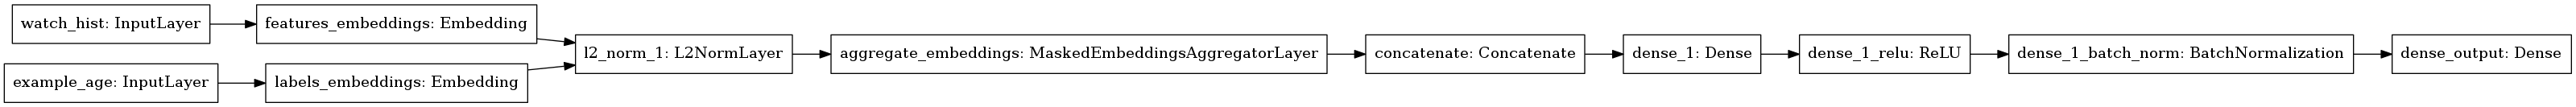

In [16]:
plot_model(model,rankdir="LR")

In [17]:
EPOCH = 50 # 100
history=model.fit([pad_sequences(train_data['watch_hist'])+ 1e-10,
                  pad_sequences(train_data['example_age'],dtype=float)+ 1e-10,
                  ],
                  pad_sequences(train_data['labels']),
                  batch_size=128, 
                  validation_split=0.1, 
                  epochs=EPOCH,
                  verbose=1)

Epoch 1/50
5/5 [==============================] - 14s 3s/step - loss: 12.1573 - acc: 0.0000e+00 - val_loss: 11.9863 - val_acc: 0.0000e+00
Epoch 2/50
5/5 [==============================] - 13s 2s/step - loss: 11.1245 - acc: 0.0074 - val_loss: 11.2518 - val_acc: 0.0000e+00
Epoch 3/50
5/5 [==============================] - 13s 2s/step - loss: 9.0341 - acc: 0.0037 - val_loss: 13.5573 - val_acc: 0.0000e+00
Epoch 4/50
5/5 [==============================] - 13s 2s/step - loss: 7.2311 - acc: 0.0056 - val_loss: 16.2544 - val_acc: 0.0000e+00
Epoch 5/50
5/5 [==============================] - 13s 2s/step - loss: 6.3202 - acc: 0.0037 - val_loss: 16.7892 - val_acc: 0.0000e+00
Epoch 6/50
5/5 [==============================] - 13s 2s/step - loss: 5.8455 - acc: 0.0111 - val_loss: 15.8049 - val_acc: 0.0000e+00
Epoch 7/50
5/5 [==============================] - 13s 2s/step - loss: 5.7159 - acc: 0.0111 - val_loss: 14.8408 - val_acc: 0.0000e+00
Epoch 8/50
5/5 [==============================] - 13s 2s/step -

Text(0.5, 1.0, 'Recall')

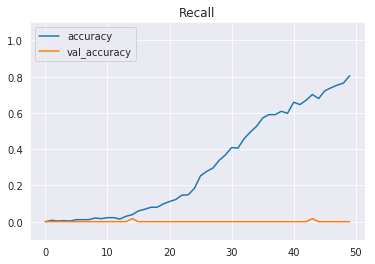

In [18]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.legend(loc='upper left')
plt.ylim(-0.1,1.1)
plt.title(f'Recall')

Text(0.5, 1.0, 'Recall')

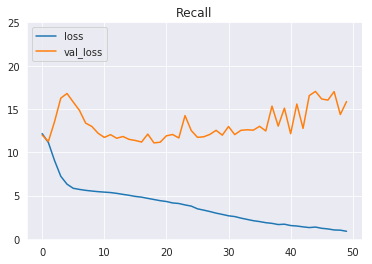

In [19]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend(loc='upper left')
# plt.title(f'Epochs={EPOCH}')
plt.ylim(-0.1,25)
plt.title(f'Recall')

In [20]:
pred = model.predict([pad_sequences(test_data['watch_hist'])+ 1e-10,
                      pad_sequences(test_data['example_age'],dtype=float)+ 1e-10,
                      ])
pred.shape # (1,193610)

(10, 193610)

In [21]:
rcmd_recall= model.predict([pad_sequences(rcmd['watch_hist'])+ 1e-10,
                            pad_sequences(rcmd['example_age'],dtype=float)+ 1e-10,
                            ])
rcmd_recall.shape

(1, 193610)

In [22]:
N = 10
k = (rcmd_recall).argsort()[:,:N]
k = k[0]
k

array([ 4701,  3864, 27831,  2021,  3106,  1282, 50872,   910,  1197,
          18])

In [23]:
rcmd["labels"][USER-1][0]

34150

In [24]:
movies = pd.read_csv("./ml-latest-small/movies.csv")
result=movies[["movieId","title"]]
result = result.set_index(['movieId']).sort_index()

print("Label:")
print("  "+result["title"][rcmd["labels"][USER-1][0]])
print("Recommend:")
for i in k:
    print("  "+result["title"][i])

Label:
  Fantastic Four (2005)
Recommend:
  Rush Hour 2 (2001)
  Godzilla 2000 (Gojira ni-sen mireniamu) (1999)
  Layer Cake (2004)
  Dune (1984)
  Come See the Paradise (1990)
  Fantasia (1940)
  Ratatouille (2007)
  Some Like It Hot (1959)
  Princess Bride, The (1987)
  Four Rooms (1995)


### Data processing

In [25]:
user_movie_list

,userId,movieId,watch_hist,labels,rating,timestamp,all_genres,example_age
0,1,"[1, 2387, 2389, 2395, 2406, 2414, 2427, 2450, ...","[1, 2387, 2389, 2395, 2406, 2414, 2427, 2450, ...",[3],"[4.0, 5.0, 2.0, 5.0, 4.0, 3.0, 5.0, 4.0, 5.0, ...","[0.1928462443, 0.1928468361, 0.1928467952, 0.1...","[8, 3, 4, 2, 6, 9, 7, 0, 5, 1]","[0.1597222222, 0.1388888889, 0.1388888889, 0.1..."
1,2,"[8798, 122882, 115713, 114060, 112552, 109487,...","[8798, 122882, 115713, 114060, 112552, 109487,...",[333],"[3.5, 5.0, 3.5, 2.0, 4.0, 3.0, 5.0, 3.5, 2.5, ...","[0.8702443550000001, 0.8702447946, 0.870244205...","[8, 4, 2, 6, 9, 7, 5, 1]","[0.0972222222, 0.0208333333, 0.0208333333, 0.0..."
2,3,"[849, 72378, 70946, 26409, 7991, 7899, 6835, 6...","[849, 72378, 70946, 26409, 7991, 7899, 6835, 6...",[2105],"[5.0, 0.5, 5.0, 4.5, 5.0, 4.5, 5.0, 0.5, 5.0, ...","[0.6740257752000001, 0.6740265544, 0.674026062...","[8, 3, 4, 2, 6, 9, 7, 5, 1]","[0.15277777780000001, 0.0625, 0.1944444444, 0...."
3,4,"[595, 599, 708, 759, 800, 892, 898, 899, 126, ...","[595, 599, 708, 759, 800, 892, 898, 899, 126, ...",[1266],"[3.0, 2.0, 4.0, 3.0, 4.0, 4.0, 5.0, 4.0, 1.0, ...","[0.2236574145, 0.1647994253, 0.223779471800000...","[8, 3, 4, 2, 6, 9, 7, 0, 5, 1]","[0.1875, 0.3402777778, 0.15277777780000001, 0...."
4,5,"[380, 318, 261, 290, 474, 364, 608, 592, 515, ...","[380, 318, 261, 290, 474, 364, 608, 592, 515, ...",[316],"[2.0, 3.0, 4.0, 5.0, 4.0, 3.0, 3.0, 3.0, 3.0, ...","[0.0272098396, 0.0272100256, 0.0272105301, 0.0...","[8, 3, 4, 2, 6, 9, 7, 5, 1]","[0.1666666667, 0.1666666667, 0.1666666667, 0.1..."
...,...,...,...,...,...,...,...,...
605,606,"[4351, 5992, 1204, 1569, 27744, 4690, 4572, 22...","[4351, 5992, 1204, 1569, 27744, 4690, 4572, 22...",[111],"[4.0, 4.0, 4.0, 4.0, 4.5, 3.5, 2.0, 4.0, 0.5, ...","[0.4837168021, 0.48658669050000003, 0.48367555...","[8, 3, 4, 2, 6, 9, 7, 0, 5, 1]","[0.1875, 0.1111111111, 0.3888888889, 0.1458333..."
606,607,"[1270, 2889, 434, 1975, 2194, 2529, 377, 695, ...","[1270, 2889, 434, 1975, 2194, 2529, 377, 695, ...",[188],"[3.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 4.0, 3.0, ...","[0.1925104058, 0.1925089066, 0.1901656947, 0.1...","[8, 3, 4, 2, 6, 9, 7, 5, 1]","[0.22916666670000002, 0.1319444444, 0.17361111..."
607,608,"[21, 2616, 588, 185, 4040, 1350, 5219, 51903, ...","[21, 2616, 588, 185, 4040, 1350, 5219, 51903, ...",[587],"[3.5, 3.5, 3.0, 3.0, 1.0, 3.5, 4.5, 2.5, 3.0, ...","[0.44962341650000004, 0.4077649908, 0.40762851...","[8, 3, 4, 2, 6, 9, 7, 0, 5, 1]","[0.1597222222, 0.1944444444, 0.1805555556, 0.1..."
608,609,"[110, 356, 1059, 650, 137, 150, 613, 457, 434,...","[110, 356, 1059, 650, 137, 150, 613, 457, 434,...",[786],"[3.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.0, ...","[0.026908634, 0.0269084635, 0.0269087242, 0.02...","[8, 3, 4, 2, 6, 9, 7, 5, 1]","[0.1597222222, 0.1666666667, 0.152777777800000..."


In [26]:
title_ids = data["title"].unique().tolist()
title2title_encoded = {x: i for i, x in enumerate(title_ids)}

In [27]:
movie_data = data.set_index(['movieId']).sort_index()
# movie_data = movie_data.loc[k+1]
movie_data = movie_data.loc[k]
movie_data = movie_data.reset_index()
movie_data 

,movieId,userId,rating,timestamp,index,title,genres,year,example_age,(no genres listed),...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,all_genres
0,4701,428,3.0,0.399288,4607,Rush Hour 2,Action|Comedy,2001,0.118056,0,...,0,0,0,0,0,0,0,0,0,"1,5"
1,4701,534,4.0,0.890075,4607,Rush Hour 2,Action|Comedy,2001,0.118056,0,...,0,0,0,0,0,0,0,0,0,"1,5"
2,4701,610,3.0,0.917910,4607,Rush Hour 2,Action|Comedy,2001,0.118056,0,...,0,0,0,0,0,0,0,0,0,"1,5"
3,4701,599,2.5,0.944647,4607,Rush Hour 2,Action|Comedy,2001,0.118056,0,...,0,0,0,0,0,0,0,0,0,"1,5"
4,4701,89,4.0,0.975495,4607,Rush Hour 2,Action|Comedy,2001,0.118056,0,...,0,0,0,0,0,0,0,0,0,"1,5"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,18,307,3.0,0.504860,17,Four Rooms,Comedy,1995,0.159722,0,...,0,0,0,0,0,0,0,0,0,5
426,18,489,2.0,0.711748,17,Four Rooms,Comedy,1995,0.159722,0,...,0,0,0,0,0,0,0,0,0,5
427,18,318,3.0,0.842962,17,Four Rooms,Comedy,1995,0.159722,0,...,0,0,0,0,0,0,0,0,0,5
428,18,103,5.0,0.850875,17,Four Rooms,Comedy,1995,0.159722,0,...,0,0,0,0,0,0,0,0,0,5


In [28]:
generate_user=movie_data[['userId']]
generate_user = generate_user.drop_duplicates()
generate_user.head(3)

,userId
0,428
1,534
2,610


In [29]:
generate_hist = movie_data.groupby(['userId'])['movieId'].apply(list).reset_index()
generate_hist.head(3)

,userId,movieId
0,1,"[1282, 1197]"
1,4,"[1282, 910, 1197]"
2,15,[50872]


In [30]:
generate_rating = movie_data.groupby(['userId'])['rating'].apply(list).reset_index()
generate_rating.head(3)

,userId,rating
0,1,"[5.0, 5.0]"
1,4,"[5.0, 5.0, 5.0]"
2,15,[3.0]


Label

In [31]:
import random
ranking_label = pd.merge(generate_user,generate_hist, how= 'left')
ranking_label = pd.merge(ranking_label,generate_rating, how= 'left')
# user_movie_list = pd.merge(user_movie_list,rating_time, how= 'left')
# user_movie_list = pd.merge(user_movie_list,genre_list, how='left')
# user_movie_list = pd.merge(user_movie_list,example_age, how='left')

# 以rating當label
# user_movie_list["labels"] = user_movie_list['userId'].apply(lambda x:([0,0,0,0,0,0,0,0,0,0]))
# for i in range(len(user_movie_list)):
#   for ii in range(len(user_movie_list["movieId"][i])):
#     for kk in range(10):
#       if (user_movie_list["movieId"][i])[ii]==k[kk]:
#         (user_movie_list["labels"][i])[kk]=(user_movie_list["rating"][i])[ii]

# 以movie當label
ranking_label["labels"] =ranking_label["userId"].apply(lambda x: [])
# # 隨機取rating最高的電影
ranking_label["rating_rand"] = ranking_label["rating"].apply(lambda x: [i+ random.uniform(0,0.001) for i in x])
for i in range(len(ranking_label)):
#     print(user_movie_list["rating"][i])
    arg=ranking_label["rating_rand"][i].index(max(ranking_label["rating_rand"][i]))
    ranking_label["labels"][i].append((ranking_label["movieId"][i])[arg])

ranking_label = ranking_label[["userId","labels"]]
ranking_label.head(5)

,userId,labels
0,428,[4701]
1,534,[1282]
2,610,[50872]
3,599,[1282]
4,89,[50872]


In [32]:
import sys
ranking_label = pd.merge(sample_data,ranking_label, how= 'left')
# for i in range(20):
#     print(k[random.randint(0,9)])
for i in range(len(ranking_label)):
    if (ranking_label["labels"])[i] != (ranking_label["labels"])[i]:
        (ranking_label["labels"])[i] = []
        (ranking_label["labels"])[i].append(k[random.randint(0,9)])

ranking_label

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,userId,labels
0,1,[1282]
1,2,[50872]
2,3,[1197]
3,4,[1197]
4,5,[3106]
...,...,...
605,606,[910]
606,607,[1282]
607,608,[2021]
608,609,[4701]


In [33]:
user_movie_list = pd.merge(sample_data,watch_hist, how= 'left')
user_movie_list = pd.merge(user_movie_list,rating, how= 'left')
user_movie_list = pd.merge(user_movie_list,rating_time, how= 'left')
user_movie_list = pd.merge(user_movie_list,genre_list, how='left')
user_movie_list = pd.merge(user_movie_list,example_age, how='left')
user_movie_list = user_movie_list[["userId","watch_hist","rating","timestamp","all_genres","example_age"]]
user_movie_list = pd.merge(user_movie_list,ranking_label, how= 'left')
user_movie_list

,userId,watch_hist,rating,timestamp,all_genres,example_age,labels
0,1,"[1, 2387, 2389, 2395, 2406, 2414, 2427, 2450, ...","[4.0, 5.0, 2.0, 5.0, 4.0, 3.0, 5.0, 4.0, 5.0, ...","[0.1928462443, 0.1928468361, 0.1928467952, 0.1...","[8, 3, 4, 2, 6, 9, 7, 0, 5, 1]","[0.1597222222, 0.1388888889, 0.1388888889, 0.1...",[1282]
1,2,"[8798, 122882, 115713, 114060, 112552, 109487,...","[3.5, 5.0, 3.5, 2.0, 4.0, 3.0, 5.0, 3.5, 2.5, ...","[0.8702443550000001, 0.8702447946, 0.870244205...","[8, 4, 2, 6, 9, 7, 5, 1]","[0.0972222222, 0.0208333333, 0.0208333333, 0.0...",[50872]
2,3,"[849, 72378, 70946, 26409, 7991, 7899, 6835, 6...","[5.0, 0.5, 5.0, 4.5, 5.0, 4.5, 5.0, 0.5, 5.0, ...","[0.6740257752000001, 0.6740265544, 0.674026062...","[8, 3, 4, 2, 6, 9, 7, 5, 1]","[0.15277777780000001, 0.0625, 0.1944444444, 0....",[1197]
3,4,"[595, 599, 708, 759, 800, 892, 898, 899, 126, ...","[3.0, 2.0, 4.0, 3.0, 4.0, 4.0, 5.0, 4.0, 1.0, ...","[0.2236574145, 0.1647994253, 0.223779471800000...","[8, 3, 4, 2, 6, 9, 7, 0, 5, 1]","[0.1875, 0.3402777778, 0.15277777780000001, 0....",[1197]
4,5,"[380, 318, 261, 290, 474, 364, 608, 592, 515, ...","[2.0, 3.0, 4.0, 5.0, 4.0, 3.0, 3.0, 3.0, 3.0, ...","[0.0272098396, 0.0272100256, 0.0272105301, 0.0...","[8, 3, 4, 2, 6, 9, 7, 5, 1]","[0.1666666667, 0.1666666667, 0.1666666667, 0.1...",[3106]
...,...,...,...,...,...,...,...
605,606,"[4351, 5992, 1204, 1569, 27744, 4690, 4572, 22...","[4.0, 4.0, 4.0, 4.0, 4.5, 3.5, 2.0, 4.0, 0.5, ...","[0.4837168021, 0.48658669050000003, 0.48367555...","[8, 3, 4, 2, 6, 9, 7, 0, 5, 1]","[0.1875, 0.1111111111, 0.3888888889, 0.1458333...",[910]
606,607,"[1270, 2889, 434, 1975, 2194, 2529, 377, 695, ...","[3.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 4.0, 3.0, ...","[0.1925104058, 0.1925089066, 0.1901656947, 0.1...","[8, 3, 4, 2, 6, 9, 7, 5, 1]","[0.22916666670000002, 0.1319444444, 0.17361111...",[1282]
607,608,"[21, 2616, 588, 185, 4040, 1350, 5219, 51903, ...","[3.5, 3.5, 3.0, 3.0, 1.0, 3.5, 4.5, 2.5, 3.0, ...","[0.44962341650000004, 0.4077649908, 0.40762851...","[8, 3, 4, 2, 6, 9, 7, 0, 5, 1]","[0.1597222222, 0.1944444444, 0.1805555556, 0.1...",[2021]
608,609,"[110, 356, 1059, 650, 137, 150, 613, 457, 434,...","[3.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.0, ...","[0.026908634, 0.0269084635, 0.0269087242, 0.02...","[8, 3, 4, 2, 6, 9, 7, 5, 1]","[0.1597222222, 0.1666666667, 0.152777777800000...",[4701]


Model

In [34]:
data["movieId"].max()+1

193610

In [35]:
EMBEDDING_DIMS = 256
DENSE_UNITS = 256 #256
DROPOUT_PCT = 0.0
ALPHA = 0.0
NUM_CLASSES=movie_data["movieId"].max()+1
# NUM_CLASSES=len(k)+1
LEARNING_RATE = 0.01

In [36]:
# Inputs
input_title = tf.keras.Input(shape=(None, ), name='movie_name')
inp_rating = tf.keras.layers.Input(shape=(None,), name='rating')
inp_timestamp = tf.keras.layers.Input(shape=(None,), name='timestamp')
input_genre = tf.keras.Input(shape=(None, ), name='genre')
input_example_age = tf.keras.Input(shape=(None, ), name='example_age')


# Embedding layers
features_embedding_layer =Embedding(input_dim=NUM_CLASSES, output_dim=EMBEDDING_DIMS, mask_zero=True, trainable=True, name='features_embeddings')
features_embeddings = features_embedding_layer(input_title)
l2_norm_features = l2_norm_1(features_embeddings)
avg_features = avg_embeddings(l2_norm_features)

labels_embedding_layer = Embedding(input_dim=NUM_CLASSES, output_dim=EMBEDDING_DIMS, mask_zero=True, trainable=True, name='labels_embeddings')
labels_rating_embeddings = labels_embedding_layer(inp_rating)
l2_norm_rating = l2_norm_1(labels_rating_embeddings)
avg_rating = avg_embeddings(l2_norm_rating)

labels_timestamp_embeddings = labels_embedding_layer(inp_timestamp)
l2_norm_timestamp = l2_norm_1(labels_timestamp_embeddings)
avg_timestamp = avg_embeddings(l2_norm_timestamp)

labels_genre_embeddings = labels_embedding_layer(input_genre)
l2_norm_genre = l2_norm_1(labels_genre_embeddings)
avg_genre = avg_embeddings(l2_norm_genre)

labels_example_age_embeddings = labels_embedding_layer(input_example_age)
l2_norm_example_age = l2_norm_1(labels_example_age_embeddings)
avg_example_age = avg_embeddings(l2_norm_example_age)


# Combine features
concat_inputs = Concatenate(axis=1)([
#                                      avg_features,
                                     avg_rating,
                                     avg_timestamp,
                                     avg_genre,
                                     avg_example_age,
                                    ])


# Dense layer
dense_1 = Dense(units=DENSE_UNITS*1, name='dense_1')
dense_1_features = dense_1(concat_inputs)
dense_1_relu = ReLU(name='dense_1_relu')(dense_1_features)
dense_3_batch_norm = BatchNormalization(name='dense_1_batch_norm')(dense_1_relu)

# dense_2 = Dense(units=DENSE_UNITS*2, name='dense_2')
# dense_2_features = dense_2(dense_1_relu)
# dense_2_relu = ReLU(name='dense_2_relu')(dense_2_features)
# dense_2_batch_norm = BatchNormalization(name='dense_2_batch_norm')(dense_2_relu)

# dense_3 = Dense(units=DENSE_UNITS, name='dense_3')
# dense_3_features = dense_3(dense_2_relu)
# dense_3_relu = ReLU(name='dense_3_relu')(dense_3_features)
# dense_3_batch_norm = BatchNormalization(name='dense_3_batch_norm')(dense_3_relu)


# Output layer
dense_output = Dense(NUM_CLASSES, activation='softmax', name='dense_output')
# dense_output = Dense(10, activation='softmax', name='dense_output')
outputs = dense_output(dense_3_batch_norm)

# Model
model_2 = tf.keras.models.Model(
    inputs=[input_title, 
            inp_rating, 
            inp_timestamp,
            input_genre,
            input_example_age,
           ],
    outputs=[outputs]
)

optimiser = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model_2.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['acc'])
# model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['acc'])
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rating (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
timestamp (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
genre (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
example_age (InputLayer)        [(None, None)]       0                                            
____________________________________________________________________________________________

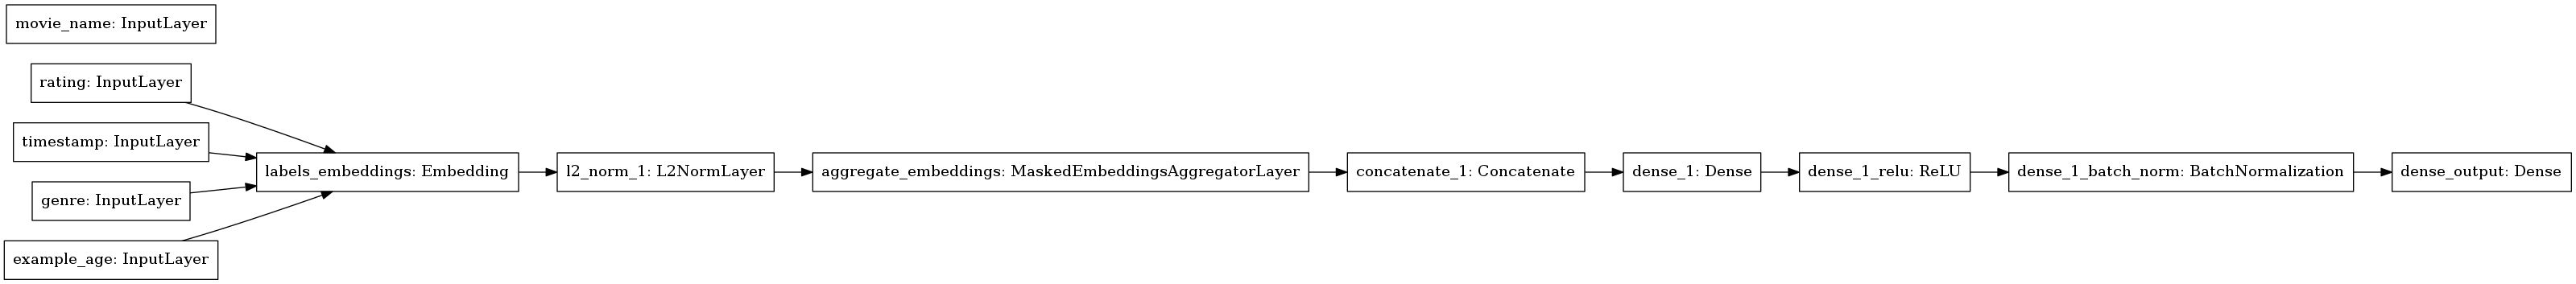

In [37]:
plot_model(model_2,rankdir="LR")

In [38]:
# tf.config.run_functions_eagerly(True)
# tf.data.experimental.enable_debug_mode()

EPOCH = 50 # 100
history_2=model_2.fit([pad_sequences(user_movie_list['watch_hist'])+ 1e-10,
        pad_sequences(user_movie_list['rating'])+ 1e-10,
        pad_sequences(user_movie_list['timestamp'])+ 1e-10,
        pad_sequences(user_movie_list['all_genres'])+ 1e-10,
        pad_sequences(user_movie_list['example_age'], dtype=float) + 1e-10,
        ],
        pad_sequences(user_movie_list['labels']),
        batch_size=128,
        validation_split=0.1,
        epochs=EPOCH,
        verbose=1)


Epoch 1/50
5/5 [==============================] - 15s 3s/step - loss: 10.6806 - acc: 0.1148 - val_loss: 10.6727 - val_acc: 0.0492
Epoch 2/50
5/5 [==============================] - 13s 3s/step - loss: 9.6248 - acc: 0.1712 - val_loss: 8.7826 - val_acc: 0.0656
Epoch 3/50
5/5 [==============================] - 13s 3s/step - loss: 7.3413 - acc: 0.1749 - val_loss: 6.7638 - val_acc: 0.0656
Epoch 4/50
5/5 [==============================] - 13s 3s/step - loss: 4.7495 - acc: 0.1876 - val_loss: 6.8103 - val_acc: 0.0656
Epoch 5/50
5/5 [==============================] - 13s 3s/step - loss: 2.8616 - acc: 0.1694 - val_loss: 4.9472 - val_acc: 0.0820
Epoch 6/50
5/5 [==============================] - 13s 3s/step - loss: 2.5166 - acc: 0.2404 - val_loss: 4.9547 - val_acc: 0.0656
Epoch 7/50
5/5 [==============================] - 13s 3s/step - loss: 2.4483 - acc: 0.2277 - val_loss: 3.6906 - val_acc: 0.0656
Epoch 8/50
5/5 [==============================] - 13s 3s/step - loss: 2.2708 - acc: 0.1676 - val_loss:

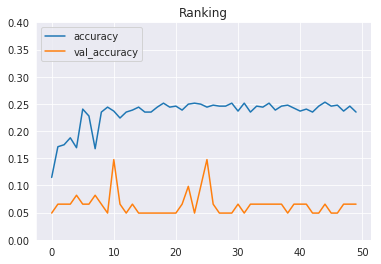

In [39]:
plt.plot(history_2.history['acc'], label='accuracy')
plt.plot(history_2.history['val_acc'], label = 'val_accuracy')
plt.title("Ranking")
plt.ylim(-0.0,0.4)
plt.legend(loc='upper left')

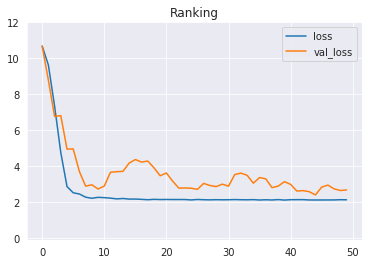

In [40]:
plt.plot(history_2.history['loss'], label='loss')
plt.plot(history_2.history['val_loss'], label = 'val_loss')
plt.title("Ranking")
plt.ylim(-0.1,12)
plt.legend(loc='upper right')

In [41]:
pred_2= model_2.predict([pad_sequences(rcmd['movieId'])+ 1e-10,
                       pad_sequences(rcmd['rating'])+ 1e-10,
                       pad_sequences(rcmd['timestamp'])+ 1e-10,
                       pad_sequences(rcmd['all_genres'])+ 1e-10,
                       pad_sequences(rcmd['example_age'],dtype=float)+ 1e-10,
                       ])
pred_2.shape

(1, 50873)

In [42]:
pred_2

array([[1.7208870e-10, 1.6729559e-10, 1.7506230e-10, ..., 1.6571498e-10,
        1.6257022e-10, 1.3430236e-01]], dtype=float32)

In [43]:
n = 10
kk = (-pred_2).argsort()[:,:n]
kk = kk[0]
print(k)
print(kk)

[ 4701  3864 27831  2021  3106  1282 50872   910  1197    18]
[ 1197  3106 50872    18   910 27831  1282  3864  2021  4701]


In [44]:
print("Label:")
print("  "+result["title"][rcmd["labels"][USER-1][0]])
print("\nCandidate generation:")
for i in k:
    print("  "+result["title"][i])
print("\nRanking:")
for i in kk:
    print("  "+result["title"][i])

print("\nUser_"+str(USER)+" watched:")
for i in (rcmd["watch_hist"][USER-1]):
    for j in kk:
        if i == j:
            aa=rcmd["watch_hist"][USER-1].index(i)
#             print("\n  "+result["title"][i])
            print("  "+result["title"][i]+
                  "    "+ "ratings: "+ str((rcmd["rating"][USER-1])[aa]))

Label:
  Fantastic Four (2005)

Candidate generation:
  Rush Hour 2 (2001)
  Godzilla 2000 (Gojira ni-sen mireniamu) (1999)
  Layer Cake (2004)
  Dune (1984)
  Come See the Paradise (1990)
  Fantasia (1940)
  Ratatouille (2007)
  Some Like It Hot (1959)
  Princess Bride, The (1987)
  Four Rooms (1995)

Ranking:
  Princess Bride, The (1987)
  Come See the Paradise (1990)
  Ratatouille (2007)
  Four Rooms (1995)
  Some Like It Hot (1959)
  Layer Cake (2004)
  Fantasia (1940)
  Godzilla 2000 (Gojira ni-sen mireniamu) (1999)
  Dune (1984)
  Rush Hour 2 (2001)

User_605 watched:
  Princess Bride, The (1987)    ratings: 5.0
